<a href="https://colab.research.google.com/github/SebasGMH/Data-Mining/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import pandas as pd
import plotly.express as px
import folium

In [1]:
"""
Covid Data Project
"""
import pandas as pd
covid_df = pd.read_csv('COVID.csv')
covid_df.shape
#reduced_df = covid_df[['DATE_OF_INTEREST','CASE_COUNT','HOSPITALIZED_COUNT','DEATH_COUNT','CASE_COUNT_7DAY_AVG']]
reduced_df = covid_df[['DATE_OF_INTEREST','CASE_COUNT']]
reduced_df.shape
# deathHospital = covid_df[['HOSPITALIZED_COUNT','DEATH_COUNT']]
# #print(deathHospital)
# fig = px.scatter(deathHospital, x='HOSPITALIZED_COUNT', y='DEATH_COUNT', 
#                  width=350, height=250)
# fig.show()

(807, 2)

<function matplotlib.pyplot.show>

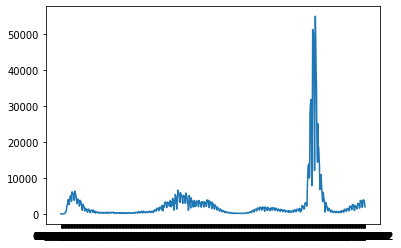

In [2]:
#reduced_df.describe()
import matplotlib.pyplot as plt
plt.plot(reduced_df['DATE_OF_INTEREST'],reduced_df['CASE_COUNT'])
plt.show


In [3]:
#interpolate zeros in cases
print((reduced_df['CASE_COUNT'] == 0).sum())
#unessesary as there are only two instances, and those instamces are not outliers

2


In [ ]:
!pip install skforecast

In [7]:
print(reduced_df.head())

         Date  CASE_COUNT
0  02/29/2020           1
1  03/01/2020           0
2  03/02/2020           0
3  03/03/2020           1
4  03/04/2020           5


In [19]:
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.75
%matplotlib inline
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Data preparation
# ==============================================================================
#reduced_df = reduced_df.rename(columns={'DATE_OF_INTEREST': 'Date'})
#reduced_df['Date'] = pd.to_datetime(reduced_df['Date'], format='%m/%d/%Y')
#reduced_df = reduced_df.set_index('Date')
#reduced_df = reduced_df.asfreq('D')
#reduced_df = reduced_df.sort_index()
#reduced_df.head()
print(reduced_df)

            CASE_COUNT
Date                  
2020-02-29           1
2020-03-01           0
2020-03-02           0
2020-03-03           1
2020-03-04           5
...                ...
2022-05-11        3874
2022-05-12        3760
2022-05-13        3314
2022-05-14        2289
2022-05-15        1953

[807 rows x 1 columns]


Train dates : 2020-02-29 00:00:00 --- 2022-04-10 00:00:00  (n=772)
Test dates  : 2022-04-11 00:00:00 --- 2022-05-15 00:00:00  (n=35)


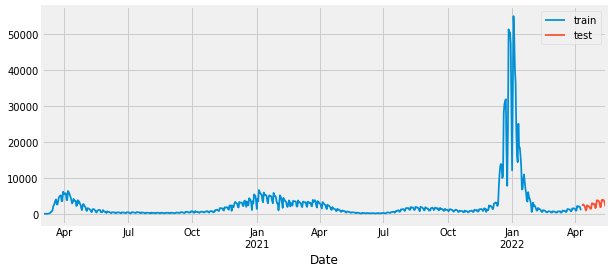

In [20]:
# Split data into train-test
# ==============================================================================
steps = 35
data_train = reduced_df[:-steps]
data_test  = reduced_df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['CASE_COUNT'].plot(ax=ax, label='train')
data_test['CASE_COUNT'].plot(ax=ax, label='test')
ax.legend();

In [21]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 62
                )

forecaster.fit(y=data_train['CASE_COUNT'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62] 
Window size: 62 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-02-29 00:00:00'), Timestamp('2022-04-10 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-05-26 03:20:51 
Last fit date: 2022-05-26 03:20:

In [33]:
# Predictions
# ==============================================================================
steps = 35
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-04-11    2619.76
2022-04-12    2522.40
2022-04-13    2899.59
2022-04-14    2683.40
2022-04-15    2134.06
Freq: D, Name: pred, dtype: float64

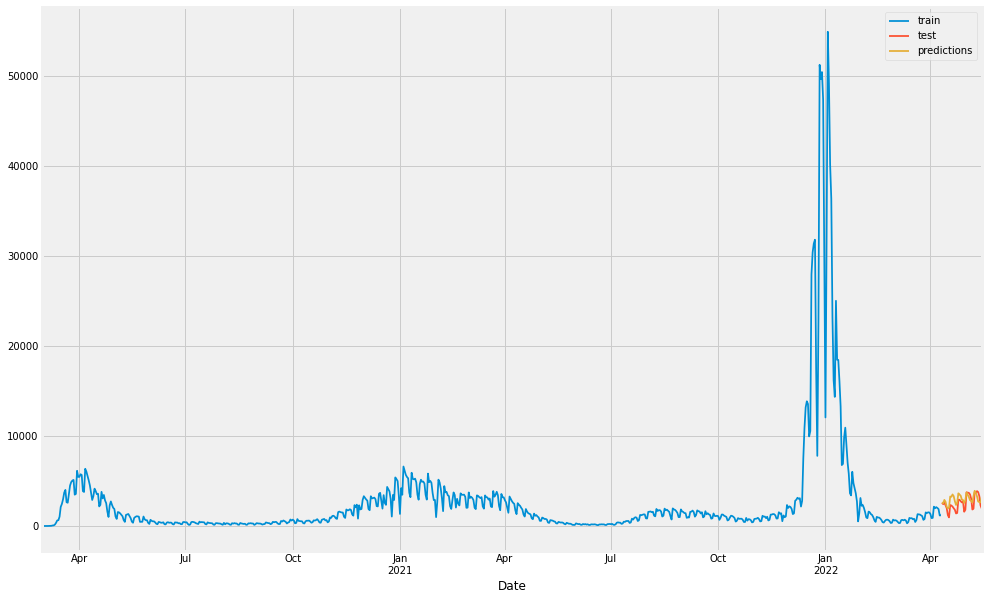

In [34]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 10))
data_train['CASE_COUNT'].plot(ax=ax, label='train')
data_test['CASE_COUNT'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [37]:
# Test error
# ==============================================================================
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_absolute_error
error_mse = mean_squared_error(
                y_true = data_test['CASE_COUNT'],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(data_test['CASE_COUNT'], predictions)
mpd = mean_poisson_deviance(data_test['CASE_COUNT'], predictions)
mae = mean_absolute_error(data_test['CASE_COUNT'], predictions)

print(f"Test error (mse): {error_mse}")
print(f"Test error (mae): {mae}")
print(f"Test error (mpd): {mpd}")
print(f"Test error (mape): {mape}")

Test error (mse): 594612.6603428571
Test error (mae): 645.9394285714286
Test error (mpd): 233.10661983494523
Test error (mape): 0.32618632965758926


In [38]:
# Hyperparameter Grid search
# ==============================================================================
steps = 35
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 104 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [31,62,93,124]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['CASE_COUNT'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 24


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [20:15<00:00, 303.94s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 41721724.96591422



In [46]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 62
             )

forecaster.fit(y=data_train['CASE_COUNT'])
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)
predictions.head()

2022-04-11    2580.209258
2022-04-12    2456.797246
2022-04-13    2837.535226
2022-04-14    2570.617748
2022-04-15    2136.669723
Freq: D, Name: pred, dtype: float64

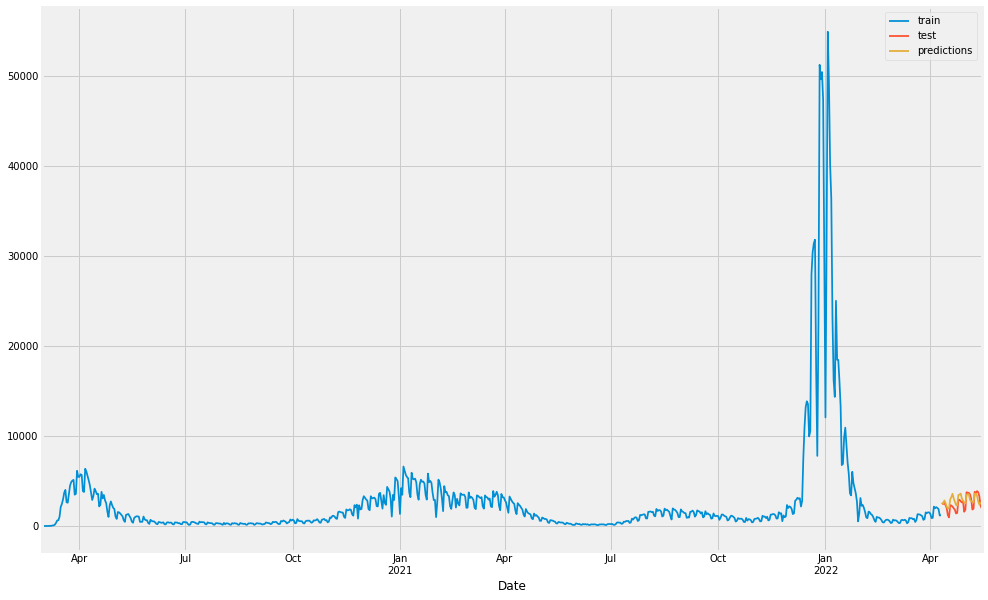

In [47]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 10))
data_train['CASE_COUNT'].plot(ax=ax, label='train')
data_test['CASE_COUNT'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [43]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['CASE_COUNT'],
                y_pred = predictions
            )
mape = mean_absolute_percentage_error(data_test['CASE_COUNT'], predictions)
mpd = mean_poisson_deviance(data_test['CASE_COUNT'], predictions)
mae = mean_absolute_error(data_test['CASE_COUNT'], predictions)

print(f"Test error (mse): {error_mse}")
print(f"Test error (mae): {mae}")
print(f"Test error (mpd): {mpd}")
print(f"Test error (mape): {mape}")

Test error (mse): 463081.0404794788
Test error (mae): 575.2166393180352
Test error (mpd): 187.24768972999357
Test error (mape): 0.2868302724554317


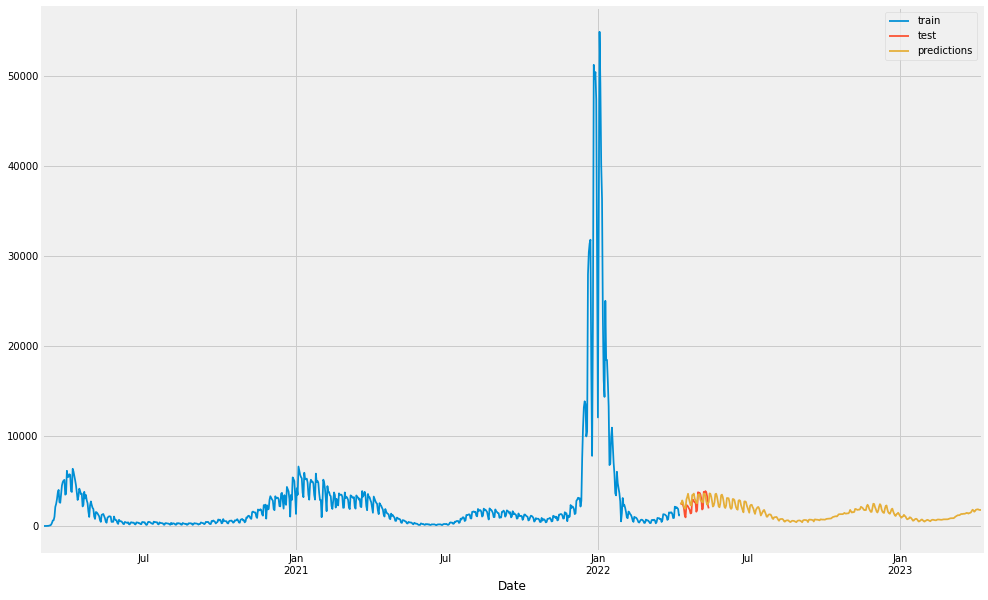

In [48]:
#predict for 365 days/ 1 year
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 62
             )

forecaster.fit(y=data_train['CASE_COUNT'])
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=365)

fig, ax = plt.subplots(figsize=(15, 10))
data_train['CASE_COUNT'].plot(ax=ax, label='train')
data_test['CASE_COUNT'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();